# 作業 : 觀察機器翻譯 Attention 內容 
- 仔細地觀察機器翻譯 Attention 結果

# [作業重點]
- 透過視覺化注意力層瞭解 Attention 的運作方式

In [1]:
import os
import re
import csv
import math
import time
import spacy
import random

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from torchtext.data import Field, BucketIterator, TabularDataset

In [2]:
# Colab 進行 matplotlib 繪圖繁體中文
# 下載字體
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
plt.style.use('seaborn-whitegrid')
# 自定義字體
myfont = FontProperties(fname='taipei_sans_tc_beta.ttf')

--2021-02-01 15:44:23--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.7.238, 2607:f8b0:4004:808::200e
Connecting to drive.google.com (drive.google.com)|172.217.7.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fqal8vqhvj10kac2i6atu3un4bu54iv6/1612194225000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-02-01 15:44:25--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fqal8vqhvj10kac2i6atu3un4bu54iv6/1612194225000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 172.217.13.65, 2607:f8b0:4004:808::2001
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|172.217.13.65|:443

機器翻譯的訓練資料來源: https://www.manythings.org/anki/

Chinese (Mandarin) - English --> cmn-eng.zip (24360)

解壓檔案並放置於 data 目錄

In [3]:
!wget https://www.manythings.org/anki/cmn-eng.zip
!unzip cmn-eng.zip -d data

--2021-02-01 15:44:27--  https://www.manythings.org/anki/cmn-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.55.222, 172.67.173.198, 2606:4700:3036::ac43:adc6, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.55.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1062383 (1.0M) [application/zip]
Saving to: ‘cmn-eng.zip’

cmn-eng.zip         100%[===================>]   1.01M  4.14MB/s    in 0.2s    

2021-02-01 15:44:27 (4.14 MB/s) - ‘cmn-eng.zip’ saved [1062383/1062383]

Archive:  cmn-eng.zip
  inflating: data/cmn.txt            
  inflating: data/_about.txt         


In [4]:
data_dir = 'data'
with open(os.path.join(data_dir, 'cmn.txt'), encoding='utf-8') as f:
    lines = f.read().strip().split('\n')
    trnslt_pairs = [l.split('\t') for l in lines]

print(f"Sample: {trnslt_pairs[1000][0:2]}")
print(f"Total records: {len(trnslt_pairs)}")

Sample: ['He was drowned.', '他被淹死了。']
Total records: 24360


將資料切分成 train/valiation/test 三個資料集，且以 csv 格式儲存在 data 目錄

In [5]:
train, test = train_test_split(trnslt_pairs, test_size=0.1)
train, val = train_test_split(train, test_size=0.1)
print(f"training data: {len(train)} , validation data: {len(val)} , testing data: {len(test)}")

def write_csv(data, file_path):
    with open(file_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        for item in data:
            writer.writerow([item[0], item[1]])

write_csv(train, os.path.join(data_dir, 'train.csv'))
write_csv(val, os.path.join(data_dir, 'val.csv'))
write_csv(test, os.path.join(data_dir, 'test.csv'))

training data: 19731 , validation data: 2193 , testing data: 2436


下載 spacy 英文/中文語料

In [6]:
import spacy.cli
spacy.cli.download("en_core_web_sm")
spacy.cli.download("zh_core_web_sm")

import en_core_web_sm, zh_core_web_sm
spacy_en, spacy_zh = en_core_web_sm.load(), zh_core_web_sm.load()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('zh_core_web_sm')


使用 torchtext 來準備訓練資料

In [7]:
def tokenize_en(text):
    # 清除不需要的字元
    text = re.sub(r'([.!?])', r' \1', text)

    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_zh(text):
    # 去掉非中文字元
    text = re.sub(r'[^\u4e00-\u9fa5A-Za-z0-9]', '', text)

    return [word.text for word in spacy_zh.tokenizer(text)]

TRG = Field(tokenize=tokenize_en, init_token='<sos>',
            eos_token='<eos>', lower=True)
SRC = Field(tokenize=tokenize_zh, init_token='<sos>', eos_token='<eos>',
            lower=True, include_lengths=True)

使用 TabularDataset 讀資料並建立辭典

In [8]:
train_dataset, dev_dataset, test_dataset = TabularDataset.splits(
    path=data_dir, format='csv', skip_header=True,
    train='train.csv', validation='val.csv', test='test.csv',
    fields=[('trg', TRG), ('src', SRC)]
)
SRC.build_vocab(train_dataset, min_freq=1)
TRG.build_vocab(train_dataset, min_freq=1)
print(f"中文語料的字元表長度: {len(SRC.vocab)}, 英文的字元表長度: {len(TRG.vocab)}")
print(f"Sample SRC: {test_dataset[0].src}, TRG: {test_dataset[0].trg}")

中文語料的字元表長度: 12388, 英文的字元表長度: 6133
Sample SRC: ['basho', '是', '最', '偉', '大', '的', '詩人'], TRG: ['basho', 'was', 'the', 'greatest', 'poet', '.']


In [9]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, dev_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device
)

重點 Attention 層(點積)

In [10]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

    def forward(self, hidden, encoder_outputs, mask):
        '''
            hidden: [batch_size, dec_hid_dim]
            encoder_outputs: [src_len, batch_size, enc_hid_dim x 2]
            mask: [batch_size , src_len]
        '''
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1)  # (batch_size, 1 dec_hid_dim)
        # (batch_size, 1, src_len)
        attention = torch.matmul(hidden , encoder_outputs.permute(1, 2, 0))
        attention = attention.squeeze(1)  # (batch_size, src_len)

        attention = attention.masked_fill(mask==0, -1e10)

        return F.softmax(attention, dim=1)

GRU 為底層的 bi-directional encoder

In [11]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)

        # bi-directional GRU encoder
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        '''
        Args:
            src: [src_len, batch_size]
            src_len: [batch_size]
        Returns:
            outputs: [src_len, batch_size, enc_hid_dim * 2]
            hidden: [batch_size, dec_hid_dim]
        '''
        # (src_len, batch_size, emb_dim)
        embedded = self.dropout(self.embedding(src))
                
        packed_embedded = pack_padded_sequence(embedded, src_len)
        # hidden: [n_layers * num_directions, batch_size, hid_dim]
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = pad_packed_sequence(packed_outputs) 
        # (src_len, batch_size, hid_dim * num_directions)
        
        # hidden[-2, :, : ] 是最後一層 forwards RNN
        # hidden[-1, :, : ] 是最後一層 backwards RNN
        hidden = torch.tanh(
            self.fc(self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        )

        return outputs, hidden

GRU 為底層的 RNN decoder

In [12]:
class RNNDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        # GRU decoder
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear(
            (enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        '''
            input: [batch_size]
            hidden: [batch_size, dec_hid_dim]
            encoder_outputs: [src_len, batch_size, enc_hid_dim * 2]
            mask: [batch_size, src_len]
        '''
        input = input.unsqueeze(0)  # (1, batch_size)
        # (1, batch_size, emb_dim)
        embedded = self.dropout(self.embedding(input))
        
        # (batch_size, src_len)
        att = self.attention(hidden, encoder_outputs, mask)
        att = att.unsqueeze(1)  # (batch_size, 1, src_len)

        # (batch_size, src_len, enc_hid_dim * 2)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # (batch_size, 1, enc_hid_dim * 2)
        weighted = torch.bmm(att, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)  # (1, batch_size, enc_hid_dim * 2)
        
        # (1, batch_size, (enc_hid_dim * 2) + emb_dim)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output: [seq_len, batch_size, dec_hid_dim * n_directions]
        # hidden: [n_layers * n_directions, batch_size, dec_hid_dim]
        
        # seq_len, n_layers and n_directions will always be 1 in this decoder, therefore:
        # output: [1, batch_size, dec_hid_dim]
        # hidden: [1, batch_size, dec_hid_dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        # (batch_size, output_dim)
        prediction = self.fc_out(self.dropout(torch.cat((output, weighted, embedded), dim=1)))
                
        return prediction, hidden.squeeze(0), att.squeeze(1)

Seq2Seq 模組

In [13]:
class Seq2SeqATTN(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)

        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        '''
            src: [src_len, batch_size]
            src_len: [batch_size]
            trg: [trg_len, batch_size]
            teacher_forcing_ratio is probability to use teacher forcing
            e.g. if teacher_forcing_ratio is 0.75, we use teacher forcing 75% of the time
        '''
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        mask = self.create_mask(src)  # (batch_size, src_len)

        for t in range(1, trg_len):
            # insert input token embedding, previous hidden state, all encoder hidden states and mask
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

建立模型和重要參數

In [14]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 256  # 注意 encoder hidden layer 設定必須為 decoder 的一半 
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

LEARNING_RATE = 0.001

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = RNNEncoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = RNNDecoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2SeqATTN(enc, dec, SRC_PAD_IDX, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

def initial_mdl_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(initial_mdl_weights)
print(f"模型全部參數量: {sum(p.numel() for p in model.parameters()):10,d} ")
model

模型全部參數量: 15,619,061 


Seq2SeqATTN(
  (encoder): RNNEncoder(
    (embedding): Embedding(12388, 256)
    (rnn): GRU(256, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): RNNDecoder(
    (attention): Attention()
    (embedding): Embedding(6133, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=6133, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

train and evalutate functions

In [15]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src, src_len = batch.src
        trg = batch.trg  # (trg_len, batch_size)
        
        # (trg_len, batch_size, output_dim)
        output = model(src, src_len.cpu() , trg)
        output_dim = output.shape[-1]
        
        # ((trg_len - 1) * batch_size, output_dim)
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)  # ((trg_len - 1) * batch_size)
        
        loss = criterion(output, trg)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, src_len = batch.src
            trg = batch.trg  # (trg_len, batch_size)

            # (trg_len, batch_size, output_dim)
            output = model(src, src_len.cpu(), trg, 0)  # turn off teacher forcing
            output_dim = output.shape[-1]

            # ((trg len - 1) * batch_size, output_dim)
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)  # ((trg len - 1) * batch_size)

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

訓練設定

In [16]:
MAX_EPOCHS = 20
CLIP = 5
model_dir = 'model'
os.makedirs(model_dir, exist_ok=True)

best_valid_loss = 9999999
for epoch in range(MAX_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    
    torch.save(model.state_dict(), os.path.join(model_dir, f"model-{epoch}.pt"))
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'best-model.pt'))
   
    print(f"Epoch {epoch} training time: {end_time - start_time:.2f} sec, "
          f"Training Loss: {train_loss:.3f} , Valiation Loss: {valid_loss:.3f}")

Epoch 0 training time: 17.98 sec, Training Loss: 5.075 , Valiation Loss: 4.770
Epoch 1 training time: 18.06 sec, Training Loss: 4.291 , Valiation Loss: 4.421
Epoch 2 training time: 18.08 sec, Training Loss: 3.819 , Valiation Loss: 4.195
Epoch 3 training time: 18.12 sec, Training Loss: 3.451 , Valiation Loss: 3.951
Epoch 4 training time: 18.08 sec, Training Loss: 3.124 , Valiation Loss: 3.833
Epoch 5 training time: 17.93 sec, Training Loss: 2.807 , Valiation Loss: 3.715
Epoch 6 training time: 17.86 sec, Training Loss: 2.563 , Valiation Loss: 3.688
Epoch 7 training time: 17.92 sec, Training Loss: 2.337 , Valiation Loss: 3.690
Epoch 8 training time: 17.95 sec, Training Loss: 2.173 , Valiation Loss: 3.639
Epoch 9 training time: 18.09 sec, Training Loss: 1.990 , Valiation Loss: 3.672
Epoch 10 training time: 17.92 sec, Training Loss: 1.885 , Valiation Loss: 3.624
Epoch 11 training time: 17.91 sec, Training Loss: 1.764 , Valiation Loss: 3.675
Epoch 12 training time: 17.95 sec, Training Loss: 

Evaluate testing set

In [17]:
model.load_state_dict(torch.load(os.path.join(model_dir, 'best-model.pt')))
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.545 | Test PPL:  34.638 |


In [18]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()
        
    tokens = [token.lower() for token in sentence]
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len.cpu())

    mask = model.create_mask(src_tensor)
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens) - 1]

選擇一句來看翻譯結果

In [19]:
example_idx = 123

src = vars(train_dataset.examples[example_idx])['src']
print(f'src = {src}')
trg = vars(train_dataset.examples[example_idx])['trg']
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')

src = ['对', '了', '你', '的', '地址', '是', '什么']
trg = ['by', 'the', 'way', ',', 'what', 'is', 'your', 'address', '?']
predicted trg = ['what', "'s", 'your', 'address', 'address', '?', '<eos>']


BLEU score evaluation

In [20]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len=50):    
    trgs, pred_trgs = [], []
    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        # cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [21]:
bleu_score = calculate_bleu(test_dataset, SRC, TRG, model, device)
print(f'BLEU score = {bleu_score * 100:.2f}')

BLEU score = 19.67


In [22]:
def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], 
                       rotation=45 , fontproperties=myfont)
    ax.set_yticklabels([''] + translation, fontproperties=myfont)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

## 作業重點
請選擇一個好的翻譯結果並將其 Attention 視覺化

In [23]:
# 請在這自行調整 sample index 觀察不同句子的 Attention 結果
example_idx = 456

src = vars(train_dataset.examples[example_idx])['src']
print(f'src = {src}')
trg = vars(train_dataset.examples[example_idx])['trg']
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')

src = ['我', '确定', '你', '不久', '就', '回来']
trg = ['i', "'m", 'sure', 'you', "'ll", 'be', 'back', 'before', 'long', '.']
predicted trg = ['i', "'m", 'sure', 'you', "'ll", 'come', 'back', 'in', 'you', '.', '<eos>']


# 觀察翻譯文和被翻譯文的語意對應

我确定你不久就回来


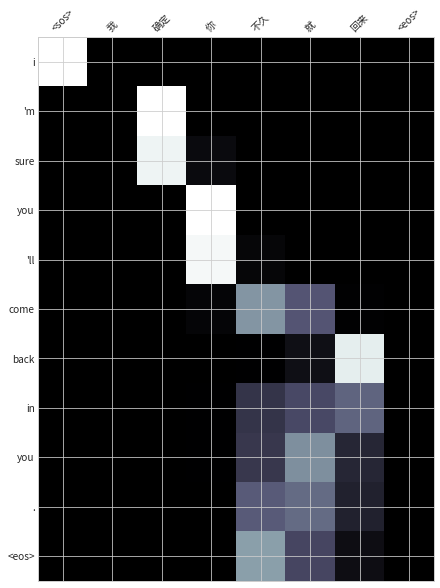

In [24]:
print(''.join(src))
display_attention(src, translation, attention)